In [1]:
import sys
import numpy as np
import scipy.optimize as opt
import pandas as pd
from matplotlib import pyplot as plt, animation
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import proplot as plot
import seaborn as sns
from tqdm import tqdm

sys.path.append('/Users/46h/Research/code/accphys')
from tools import envelope_analysis as ea
from tools import plotting as myplt
from tools import animation as myanim
from tools import utils
from tools.utils import show

In [2]:
plot.rc['figure.facecolor'] = 'white'
plot.rc['cycle'] = 'default'
plot.rc['savefig.dpi'] = 'figure'
plot.rc['animation.html'] = 'jshtml'

save_figures = True
def save(figname):
    if save_figures:
        plt.savefig(''.join(['_output/figures/', figname, '.png']), facecolor='white', dpi=250)

# 4D Measurement in RTBT
> This notebook reconstructs the beam covariance matrix at the entrance of the Ring to Target Beam Transport (RTBT) section of the Spallation Neutron Source (SNS).

<img src="_fig/rtbt.png" width=800>

## Method summary

The goal is to reconstruct the transverse beam covariance matrix at position $s = s_0$:

$$
\Sigma_{0} = \begin{bmatrix}
    \langle{x^2}\rangle & \langle{xx'}\rangle & \langle{xy}\rangle & \langle{xy'}\rangle \\
    \langle{xx'}\rangle & \langle{{x'}^2}\rangle & \langle{yx'}\rangle & \langle{x'y'}\rangle \\
    \langle{xy}\rangle & \langle{yx'}\rangle & \langle{y^2}\rangle & \langle{yy'}\rangle \\
    \langle{xy'}\rangle & \langle{x'y'}\rangle & \langle{yy'}\rangle & \langle{{y'}^2}\rangle
\end{bmatrix}.
$$

To do this, a set of $n$ wire-scanners can be placed at positions $\{s_i\} > s_0$ with $i = 1, ..., n$. A single measurement from wire-scanner $i$ will produce the real-space moments of the beam at $s_i$: $\langle{x^2}\rangle_{i}$, $\langle{y^2}\rangle_{i}$, and $\langle{xy}\rangle_{i}$. Without space charge, the transfer matrix $M_{s_0 \rightarrow s_i} = M_i$ is known. The moments at $s_0$ are then directly related to those at $s_i$ by

$$\Sigma_i = M_i \Sigma_{0} {M_i}^T.$$ This gives <br>

$$
\begin{align}
    \langle{x^2}\rangle_i &= 
        m_{11}^2\langle{x^2}\rangle_{0} 
      + m_{12}^2\langle{x'^2}\rangle_{0} 
      + 2m_{11}m_{22}\langle{xx'}\rangle_{0} ,\\
    \langle{y^2}\rangle_i &= 
        m_{33}^2\langle{y^2}\rangle_{0} 
      + m_{34}^2\langle{y'^2}\rangle_{0} 
      + 2m_{33}m_{34}\langle{yy'}\rangle_{0} ,\\
    \langle{xy}\rangle_i &= 
        m_{11}m_{33}\langle{xy}\rangle_{0} 
      + m_{12}m_{33}\langle{yx'}\rangle_{0} 
      + m_{11}m_{34}\langle{xy'}\rangle_{0} 
      + m_{12}m_{34}\langle{x'y'}\rangle_{0} ,
\end{align}
$$

where $m_{lm}$ are the elements of the transfer matrix. Taking 3 measurements with different sets of optics between $s_0$ and $s_i$ (and therefore different transfer matrices) gives the 10 equations necessary to solve for $\Sigma_0$; however, real measurements will be noisy, so it is better to take more measurements if possible. Given $N$ measurements, we can form a $3N \times 1$ observation array $b$ from the measured moments and a $3N \times 10$ coefficient array $A$ from the transfer matrix such that

$$\begin{align} \mathbf{A \sigma}_0 = \mathbf{b},\end{align}$$ 

where $\mathbf{\sigma}_0$ is a $10 \times 1$ vector of the moments at $s_0$. There are 5 wire-scanners in the RTBT which operate simultaneously, and it is probably feasible to take around 25 measurements. We then choose $\mathbf{\sigma}_0$ such that $|\mathbf{A\sigma}_0 - \mathbf{b}|^2$ is minimized. 

## RTBT lattice functions 

In [5]:
twiss = pd.read_csv('_output/data/twiss.dat')
ws_positions = np.loadtxt('_output/data/ws_positions.dat')

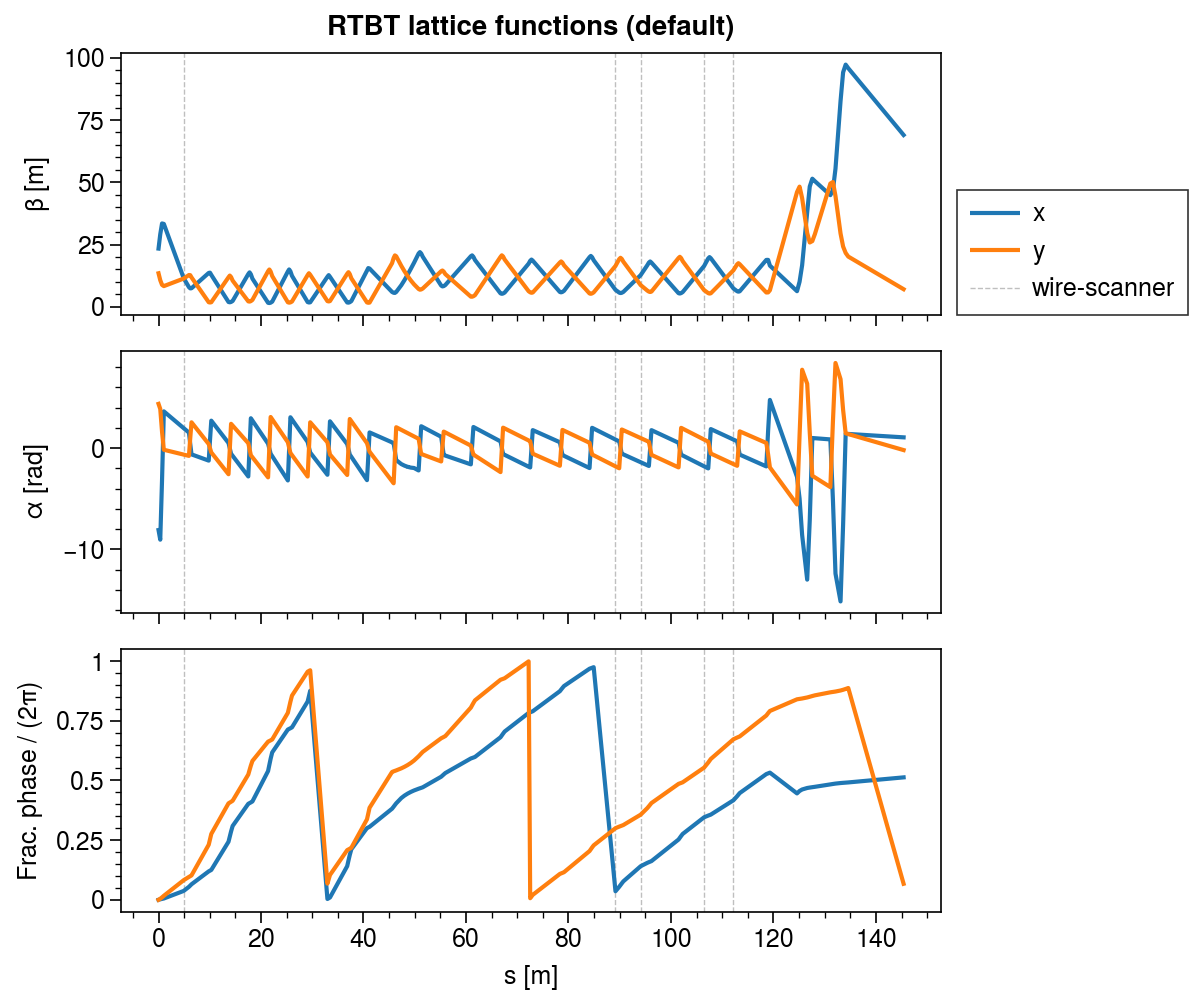

In [24]:
fig, axes = plot.subplots(nrows=3, figsize=(6, 5), spany=False)
ax1, ax2, ax3 = axes
twiss[['s','bx','by']].plot('s', ax=ax1, legend=False)
twiss[['s','ax','ay']].plot('s', ax=ax2, legend=False)
twiss[['s','nux','nuy']].plot('s', ax=ax3, legend=False)
axes.format(xlabel='s [m]', toplabels='RTBT lattice functions (default)', grid=False)
for ax, ylabel in zip(axes, [r'$\beta$ [m]', r'$\alpha$ [rad]', 'Frac. phase / ($2\pi$)']):
    ax.format(ylabel=ylabel);
    for ws_position in ws_positions:
        ax.axvline(ws_position, color='grey', ls='--', lw=0.5, alpha=0.5, zorder=0)
ax1.legend(labels=['x', 'y', 'wire-scanner'], ncols=1, loc=(1.02, 0));
save('twiss_default')

## Phase scan 

In [ ]:
ws_names = ['ws02', 'ws20', 'ws21', 'ws23', 'ws24']
ws_names_to_use_in_scan = ws_names[:]

In [ ]:
def load(file, ws_name):
    path = '_output/data/{}_{}.npy'.format(file, ws_name)
    return np.load(path)

moments_dict, transfer_mats_dict, phase_advances_dict, env_params_dict = {}, {}, {}, {}
for ws_name in ws_names:
    moments_dict[ws_name] = 1e6 * load('moments', ws_name)
    transfer_mats_dict[ws_name] = load('transfer_mats', ws_name)
    phase_advances_dict[ws_name] = load('phase_advances', ws_name)
    env_params_dict[ws_name] = 1e3 * load('env_params', ws_name)
    
if type(ws_names_to_use_in_scan) is str:
    ws_names_to_use_in_scan = [ws_names_to_use_in_scan]
moments = np.vstack([moments_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
transfer_mats = np.vstack([transfer_mats_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
phase_advances = np.vstack([phase_advances_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
env_params = np.vstack([env_params_dict[ws_name] for ws_name in ws_names_to_use_in_scan])
Sigma0 = 1e6 * np.load('_output/data/Sigma0.npy')

Observe the beam at the wire-scanners. Any greyed-out wire-scanners are not used in the reconstruction.

In [ ]:
fig, axes = plot.subplots(ncols=5, figsize=(11, 2.25))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(phase_advances_dict[ws_name] % 1, marker='.', ms=3);
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
axes.format(ylabel='Frac. phase / ($2\pi$)', xlabel='Scan index', suptitle='Phase advance at wire-scanner')
axes[0].legend(labels=['x', 'y'], ncols=3);
save('ws_phase_adv')

In [ ]:
fig, axes = plot.subplots(ncols=5, figsize=(11, 2.25))
for ax, ws_name in zip(axes, ws_names):
    ax.plot(moments_dict[ws_name][:, 0], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 1], marker='.', ms=3)
    ax.plot(moments_dict[ws_name][:, 2], marker='.', ms=3)
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
axes.format(ylabel='[mm$^2$]', xlabel='Scan index', suptitle='Beam moments at wire-scanner')
axes[0].legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], fontsize='small');
save('ws_moments')

<center><b>Beam envelope at wire-scanner<b><center>

In [ ]:
coords_list = [ea.get_ellipse_coords(env_params_dict[ws_name]) for ws_name in ws_names]

pad = 0.25
limits_list = np.array([(1 + pad) * myplt.get_u_up_max_global(coords) for coords in coords_list])
umax, _ = np.max(limits_list, axis=0)

fig, ax_list = plt.subplots(ncols=6, figsize=(13, 1.75), sharex=True, sharey=True)
axes, text_ax = ax_list[:-1], ax_list[-1]
text_ax.grid(False)
myplt.despine([text_ax], 'all')
myplt.despine(axes)
axes[0].set_xlim(-umax, umax);  axes[0].set_ylim(-umax, umax)
axes[0].set_yticks(axes[0].get_xticks())
axes[0].set_xlabel('x [mm]');  axes[0].set_ylabel('y [mm]')
for ax, ws_name in zip(axes, ws_names):
    ax.set_title(ws_name, color='grey' if ws_name not in ws_names_to_use_in_scan else 'k')
    ax.grid(False)
plt.close()

def update(t):
    for ax, coords in zip(axes, coords_list):
        for patch in ax.patches:
            patch.remove()
        ax.fill(coords[t, :, 0], coords[t, :, 2], fc='lightsteelblue', ec='k', zorder=10)
    for text in text_ax.texts:
        text.remove()
    text_ax.annotate('Scan index = {}'.format(t), xy=(0.25, 0.5), xycoords='axes fraction', horizontalalignment='center')

nframes = coords_list[0].shape[0]
anim = animation.FuncAnimation(fig, update, frames=nframes, interval=1000/1)
if save_figures:
     anim.save('_output/figures/ws_envelope.mp4', dpi=300)
anim

## Reconstruction

In [ ]:
# method = 'trust-constr'
method = 'lsq_linear'

In [ ]:
def to_mat(sigma):
    """Return covariance matrix from 10 element moment vector."""
    s11, s22, s12, s33, s44, s34, s13, s23, s14, s24 = sigma
    return np.array([[s11, s12, s13, s14], 
                     [s12, s22, s23, s24], 
                     [s13, s23, s33, s34], 
                     [s14, s24, s34, s44]])

def to_vec(Sigma):
    """Return 10 element moment vector from covariance matrix."""
    s11, s12, s13, s14 = Sigma[0, :]
    s22, s23, s24 = Sigma[1, 1:]
    s33, s34 = Sigma[2, 2:]
    s44 = Sigma[3, 3]
    return np.array([s11, s22, s12, s33, s44, s34, s13, s23, s14, s24])

In [ ]:
def solve(A, b, guess=None, method='lsq_linear', **options):
    """Reconstruct covariance matrix from measured data.
    
    Solves the problem A.sigma = b, where sigma is the vector
    of 10 beam moments at the reconstruction point and A and 
    b are defined below.
    
    Parameters
    ----------
    A : ndarray, shape (3n, 10)
        Coefficient array determined by transfer matrix elements.
    b : ndarray, shape (3n,)
        Observation array determined by beam moments at measurement location.
    guess : ndarray, shape (10,) or None
        Initial guess.
    method : {'lsq_linear', 'trust-constr'}
        Optimization method to use. 'lsq_linear' runs linear least-squares
        without requirement that covariance matrix remains physical.
    **options
        Arguments for solver.

    Returns
    -------
    ndarray, shape (4, 4)
        Covariance matrix at reconstruction point.
    """
    if guess is None:
        guess = to_vec(np.diag([100, 10, 100, 10]))
        
    def cost(sigma, A, b):
        return 0.5 * np.sum((np.matmul(A, sigma) - b)**2)

    # Squared moments can't be negative
    lb = 10 * [-np.inf]
    lb[0] = lb[1] = lb[3] = lb[4] = 0.0 
    bounds = opt.Bounds(lb, np.inf, keep_feasible=False)
    
    # Correlation coefficients must be in range [-1, 1]
    def corr_coeffs(sigma):
        return to_vec(utils.cov2corr(to_mat(sigma)))
    constr = opt.NonlinearConstraint(corr_coeffs, -1, 1, keep_feasible=False) 
        
    if method == 'lsq_linear':
        result = opt.lsq_linear(A, b, bounds=(lb, np.inf), **options)
    else:
        result = opt.minimize(cost, guess, args=(A, b), method=method,
                              bounds=bounds, constraints=constr, options=options)
    return to_mat(result.x)

Form coefficent and observation arrays.  

In [ ]:
A, b = [], []
for M, (x2, y2, xy) in zip(transfer_mats, moments):
    A.append([M[0, 0]**2, M[0, 1]**2, 2*M[0, 0]*M[0, 1], 0, 0, 0, 0, 0, 0, 0])
    A.append([0, 0, 0, M[2, 2]**2, M[2, 3]**2, 2*M[2, 2]*M[2, 3], 0, 0, 0, 0])
    A.append([0, 0, 0, 0, 0, 0, M[0, 0]*M[2, 2],  M[0, 1]*M[2, 2],  M[0, 0]*M[2, 3],  M[0, 1]*M[2, 3]])
    b.append(x2)
    b.append(y2)
    b.append(xy)
A, b = np.array(A), np.array(b)

In [ ]:
guess = to_vec(Sigma0) 
Sigma = solve(A, b, guess, method, verbose=1)
print()
show(Sigma, 'Sigma')
print()
show(Sigma0, 'Sigma0')
print()
show(Sigma - Sigma0, 'Sigma - Sigma0')

axes = myplt.rms_ellipses(Sigma, color='blue8', lw=2)
myplt.rms_ellipses(Sigma0, axes=axes, color='red8', lw=1);
handles = [Line2D([0], [0], color='red8'), Line2D([0], [0], color='blue8')]
axes[1, 1].legend(handles, ['True', 'Reconstructed'], loc=(1.02, 1.02));
save('projection_default')

## Errors 

### Initial guess

In [ ]:
eps_ideal = ea.intrinsic_emittances(Sigma0)
emittances, Sigmas = {}, {}

In [ ]:
def plot_emittance_comparison(varied_parameters, emittances, xlabel='', figname=None):
    emittances = np.array(emittances)
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    for i, color in enumerate(['green8', 'pink8']):
        ax.axhline(eps_ideal[i], ls='-', lw=1, color=color, alpha=0.2)
        ax.scatter(varied_parameters, emittances[:, i], c=color, s=10)
    ax.format(xlabel=xlabel, ylabel='[mm $\cdot$ mrad]', title='Reconstructed intrinsic emittance', grid=False)
    ax.legend(labels=[r'$\varepsilon_{1, true}$', r'$\varepsilon_{2, true}$', 
                      r'$\varepsilon_{1, meas}$', r'$\varepsilon_{2, meas}$'], ncols=1, loc=(1.02, 0))
    if figname:
        save(figname)
    plt.show()
    
def plot_moment_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, ax = plot.subplots(figsize=(5.5, 2.5))
    Sigmas = np.array(Sigmas)
    colors = ['blue8', 'orange6', 'green8']
    for color, i, j in zip(colors, [0, 2, 0], [0, 2, 2]):
        ax.axhline(Sigma0[i, j], color=color, alpha=0.2)
        ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c=color);
    ax.format(xlabel=xlabel, ylabel='[mm$^2$]', title='Reconstructed moments', grid=False)
    ax.legend(labels=[r'$\langle{x^2}\rangle$', r'$\langle{y^2}\rangle$', r'$\langle{xy}\rangle$'], ncols=1, loc=(1.02, 0));
    if figname:
        save(figname)
    plt.show()
    
def plot_all_moments_comparison(varied_parameters, Sigmas, Sigma0, xlabel='', figname=None):
    fig, axes = plot.subplots(nrows=4, ncols=4, figsize=(10, 6), sharey=False, spany=False, aligny=True)
    myplt.make_lower_triangular(axes)
    axes.format(xlabel=xlabel, suptitle='Reconstructed moments', grid=False)
    Sigmas = np.array(Sigmas)
    for i in range(4):
        for j in range(i + 1):
            ax = axes[i, j]
            ax.axhline(Sigma0[i, j], color='red8', alpha=0.2)
            ax.scatter(varied_parameters, Sigmas[:, i, j], marker='.', c='k')
            ax.format(title=utils.get_moments_label(i, j))
    myplt.set_labels(axes[0:, 0], [r'[mm$^2$]', r'[mm$\cdot$mrad]', r'[mm$^2$]', r'mm$\cdot$mrad'], 'ylabel')
    myplt.set_labels(axes[1:, 1], [r'[mrad$^2$]', r'[mm$\cdot$mrad]', r'[mrad$^2$]'], 'ylabel')
    myplt.set_labels(axes[2:, 2], [r'[mm$^2$]', r'[mm$\cdot$mrad]'], 'ylabel')
    myplt.set_labels(axes[3:, 3], [r'[mrad$^2$]'], 'ylabel')
    if figname:
        save(figname)
    plt.show()
    
def plot_rms_ellipse_comparison(Sigmas, Sigma0, figsize=(4.5, 4.5), figname=None):
    axes = myplt.rms_ellipses(Sigmas, color='blue8', lw=0.5)
    myplt.rms_ellipses(Sigma0, axes=axes, color='red8', lw=2);
    handles = [Line2D([0], [0], color='red8'), Line2D([0], [0], color='blue8')]
    axes[1, 1].legend(handles, ['True', 'Reconstructed'], loc=(1.02, 1.02));
    if figname:
        save(figname)
    plt.show()

#### Random perturbation

Here we perturb the 4D Twiss parameters describing the initial guess, which are originally set to $\Sigma0$. Each parameters $p$ is updated to a random value the range [$(1 - r)p$, $(1 + r)p$], with $r$ being the perturbation radius.

In [ ]:
def perturb(Sigma0, radius=0.0):
    env = ea.Envelope()
    env.fit_cov(Sigma0)
    env.perturb(radius)
    return env.cov()

r_min, r_max = (0.0, 0.5)
nsteps = 25
trials_per_step = 3

radii = np.repeat(np.linspace(r_min, r_max, nsteps), trials_per_step)
emittances['guess_err_rand'], Sigmas['guess_err_rand'] = [], []
for radius in tqdm(radii):
    guess = to_vec(perturb(Sigma0, radius))
    Sigma = solve(A, b, guess, method, verbose=0)
    e1, e2 = ea.intrinsic_emittances(Sigma)
    emittances['guess_err_rand'].append([e1, e2])
    Sigmas['guess_err_rand'].append(Sigma)

In [ ]:
xlabel = 'Perturbation radius'
plot_emittance_comparison(radii, emittances['guess_err_rand'], xlabel, figname='emittance_guess_err_rand')
plot_moment_comparison(radii, Sigmas['guess_err_rand'], Sigma0, xlabel, figname='moments_guess_err_rand')
plot_all_moments_comparison(radii, Sigmas['guess_err_rand'], Sigma0, xlabel, figname='moments_all_guess_err_rand')
plot_rms_ellipse_comparison(Sigmas['guess_err_rand'], Sigma0, figname='projection_guess_err_rand')

#### The $\nu$ parameter

I assume the 2D beam Twiss parameters are somewhat close to the machine optics. What I'm not surea about is the $\nu$ parameter, which will strongly affect the cross-plane moments. In this example I've chosen $\nu = \pi/2$ for the initial beam. Below we vary $\nu$ in the initial guess of the reconstructed parameters.

In [ ]:
def change_nu(Sigma0, nu=0.0):
    env = ea.Envelope()
    env.fit_cov(Sigma0)
    env.set_twiss_param_4D('nu', np.radians(nu))
    return env.cov()

nu_min, nu_max = (0, 180)
nsteps = 25
trials_per_step = 3

nus = np.repeat(np.linspace(nu_min, nu_max, nsteps), trials_per_step)
emittances['guess_err_nu'], Sigmas['guess_err_nu'] = [], []
for nu in tqdm(nus):
    guess = to_vec(change_nu(Sigma0, nu))
    Sigma = solve(A, b, guess, method, verbose=0)
    emittances['guess_err_nu'].append(ea.intrinsic_emittances(Sigma))
    Sigmas['guess_err_nu'].append(Sigma)

In [ ]:
xlabel = r'$\nu$ [deg]'
plot_emittance_comparison(nus, emittances['guess_err_nu'], xlabel, figname='emittance_guess_err_nu')
plot_moment_comparison(nus, Sigmas['guess_err_nu'], Sigma0, xlabel, figname='moments_guess_err_nu')
plot_all_moments_comparison(nus, Sigmas['guess_err_nu'], Sigma0, xlabel, figname='moments_all_guess_err_nu')
plot_rms_ellipse_comparison(Sigmas['guess_err_nu'], Sigma0, figname='projection_guess_err_nu')

### Measurement

Here we add Gaussian noise to each measured moment.

In [ ]:
def blur(array, stdev=1.0, mean=0.0):
    return array + np.random.normal(loc=mean, scale=stdev, size=b.shape)

guess = to_vec(Sigma0)
stdev_min, stdev_max = (0.0, 25.0) # [mm^2]
nsteps = 25
trials_per_step = 3

stdevs = np.repeat(np.linspace(stdev_min, stdev_max, nsteps), trials_per_step)
emittances['meas_err'], Sigmas['meas_err'] = [], []
for stdev in tqdm(stdevs):
    Sigma = solve(A, blur(b, stdev), guess, method, verbose=0)
    emittances['meas_err'].append(ea.intrinsic_emittances(Sigma))
    Sigmas['meas_err'].append(Sigma)

In [ ]:
xlabel = 'Std. dev. [mm^2]'
plot_emittance_comparison(stdevs, emittances['meas_err'], xlabel, figname='emittance_meas_err')
plot_moment_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_meas_err')
plot_all_moments_comparison(stdevs, Sigmas['meas_err'], Sigma0, xlabel, figname='moments_all_meas_err')
plot_rms_ellipse_comparison(Sigmas['meas_err'], Sigma0, figname='projection_meas_err')

## Comments 